In [868]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, \
    KFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, roc_curve, confusion_matrix
import xgboost as xgb

%config InlineBackend.figure_format = 'png'
%matplotlib inline
sns.set(color_codes=True)
plt.style.use('seaborn-colorblind')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 2)
pd.set_option('display.max_info_columns', 200)

## Data Loading ##

In [596]:
numeric_cols = ['Cloud Cover', 'Dew Point', 'Heat Index', 'Latitude', 'Longitude',
                'Maximum Temperature', 'Precipitation', 'Precipitation Cover', 'Relative Humidity',
                'Sea Level Pressure', 'Snow Depth', 'Temperature', 'Visibility',
                'Wind Chill', 'Wind Direction', 'Wind Gust', 'Wind Speed']

In [600]:
weather_df[numeric_cols] = weather_df[numeric_cols].apply(pd.to_numeric)

In [601]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40109 entries, 0 to 40108
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Address              40109 non-null  object 
 1   Cloud Cover          40101 non-null  float64
 2   Conditions           40109 non-null  object 
 3   Date time            40109 non-null  object 
 4   Dew Point            40099 non-null  float64
 5   Heat Index           14635 non-null  float64
 6   Info                 40109 non-null  object 
 7   Latitude             40109 non-null  float64
 8   Longitude            40109 non-null  float64
 9   Maximum Temperature  40101 non-null  float64
 10  Minimum Temperature  40109 non-null  object 
 11  Name                 40109 non-null  object 
 12  Precipitation        40101 non-null  float64
 13  Precipitation Cover  40101 non-null  float64
 14  Relative Humidity    40099 non-null  float64
 15  Resolved Address     40109 non-null 

In [632]:
weather_df['date_str'] = pd.to_datetime(weather_df['Date time']).astype(str)

In [655]:
weather_df[(weather_df['Address'] == '35.81249,-83.99286') & (weather_df['date_str'] == '2015-05-10')]

,Address,Cloud Cover,Conditions,Date time,Dew Point,Heat Index,Info,Latitude,Longitude,Maximum Temperature,Minimum Temperature,Name,Precipitation,Precipitation Cover,Relative Humidity,Resolved Address,Sea Level Pressure,Snow Depth,Temperature,Visibility,Weather Type,Wind Chill,Wind Direction,Wind Gust,Wind Speed,date_str
33402,"35.81249,-83.99286",65.4,Partially cloudy,05/10/2015,61.4,86.2,,35.81249,-83.99286,86.1,66.8,,0.0,0.0,63.27,"35.81249,-83.99286",1018.3,NaN,75.6,1.0,,NaN,203.83,NaN,8.1,2015-05-10


In [602]:
with open('pickles/weather_df2.pickle', 'wb') as to_write:
    pickle.dump(weather_df, to_write)

In [591]:
with open('pickles/weather_df.pickle', 'rb') as read_file:
    weather_df = pickle.load(read_file)

In [869]:
with open('pickles/combined_sample_weather_df5.pickle', 'wb') as to_write:
    pickle.dump(sample_df, to_write)

In [871]:
with open('pickles/cv_records_df.pickle', 'wb') as to_write:
    pickle.dump(cv_records_df, to_write)

In [486]:
with open('pickles/combined_error_analysis_df.pickle', 'wb') as to_write:
    pickle.dump(combined_error_analysis_df, to_write)

In [722]:
with open('pickles/feature_engineering_sample_df9.pickle', 'rb') as read_file:
    sample_df = pickle.load(read_file)

In [498]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 77 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   year                                      100000 non-null  int64  
 1   month                                     100000 non-null  int64  
 2   day                                       100000 non-null  int64  
 3   day_of_week                               100000 non-null  int64  
 4   airline                                   100000 non-null  object 
 5   flight_number                             100000 non-null  int64  
 6   tail_number                               99757 non-null   object 
 7   origin_airport                            100000 non-null  object 
 8   destination_airport                       100000 non-null  object 
 9   scheduled_departure                       100000 non-null  object 
 10  departure_time       

In [6]:
with open('cv_records.pickle', 'rb') as read_file:
    cv_records = pickle.load(read_file)

In [7]:
cv_records

[{'model': 'logistic',
  'iteration_desc': 'baseline',
  'feature_engineering': '',
  'hyperparameter_tuning': '',
  'mean_train_f1': 0.0,
  'mean_val_f1': 0.0,
  'mean_train_precision': 0.0,
  'mean_val_precision': 0.0,
  'mean_train_recall': 0.0,
  'mean_val_recall': 0.0,
  'mean_train_accuracy': 0.8326874999999999,
  'mean_val_accuracy': 0.8326875000000001}]

In [236]:
sample_df['is_not_on_time'] = np.where((sample_df['arrival_delay'] >= 15) | (sample_df['diverted'] == 1) |
                                       (sample_df['cancelled'] == 1), 1, 0)

In [237]:
sample_df.is_not_on_time.value_counts()

0    79873
1    20127
Name: is_not_on_time, dtype: int64

In [4]:
sample_df.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time
0,2015,2,13,5,EV,4210,N26141,IAH,BNA,1904,1900,-4.0,18.0,1918,107,113.0,89.0,657,2047,6.0,2051,2053,2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,Nashville International Airport,Nashville,TN,36.12,-86.68,0
1,2015,6,21,7,WN,511,N7714B,DEN,CMH,1835,1831,-4.0,11.0,1842,165,157.0,140.0,1154,2302,6.0,2320,2308,-12.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,Denver International Airport,Denver,CO,39.86,-104.67,Port Columbus International Airport,Columbus,OH,40.00,-82.89,0
2,2015,2,18,3,AA,1271,N3ESAA,SNA,DFW,1217,1210,-7.0,12.0,1222,168,168.0,139.0,1205,1641,17.0,1705,1658,-7.0,0,0,None,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,John Wayne Airport (Orange County Airport),Santa Ana,CA,33.68,-117.87,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,32.90,-97.04,0
3,2015,8,26,3,DL,1925,N963DN,ATL,BWI,0730,0729,-1.0,16.0,0745,110,104.0,81.0,577,0906,7.0,0920,0913,-7.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Delta Air Lines Inc.,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,33.64,-84.43,Baltimore-Washington International Airport,Baltimore,MD,39.18,-76.67,0
4,2015,6,1,1,WN,3301,N793SA,SAT,DAL,1250,1244,-6.0,11.0,1255,60,64.0,48.0,248,1343,5.0,1350,1348,-2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,San Antonio International Airport,San Antonio,TX,29.53,-98.47,Dallas Love Field,Dallas,TX,32.85,-96.85,0


In [5]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   year                           100000 non-null  int64  
 1   month                          100000 non-null  int64  
 2   day                            100000 non-null  int64  
 3   day_of_week                    100000 non-null  int64  
 4   airline                        100000 non-null  object 
 5   flight_number                  100000 non-null  int64  
 6   tail_number                    99757 non-null   object 
 7   origin_airport                 100000 non-null  object 
 8   destination_airport            100000 non-null  object 
 9   scheduled_departure            100000 non-null  object 
 10  departure_time                 98518 non-null   object 
 11  departure_delay                98518 non-null   float64
 12  taxi_out                       

## Functions ##

In [8]:
def initial_split(X, y):
    """Splits features and target dataframes in 80/20 ratio.

    Args:
        X: A dataframe only consisting of the features.
        y: A dataframe only consisting of the target.

    Returns:
        X_train_val: A dataframe, containing 80% of the original features data,
            to be used for training and validation.
        X_test: A dataframe, containing 20% of the original features data, to be
            used for testing.
        y_train_val: A dataframe, containing 80% of the original target data, to
            be used for training and validation.
        y_test: A dataframe, containing 20% of the original target data, to be
            used for testing.
    """
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=4444)
    return X_train_val, X_test, y_train_val, y_test

In [9]:
def second_split(X_train_val, y_train_val):
    """Splits features and target dataframes so training set
    is 60% of all data and validation set is 20% of all data.

    Args:
        X_train_val: A dataframe, containing 80% of the original features data,
            to be used for training and validation. 
        y_train_val: A dataframe, containing 80% of the original target data, to
            be used for training and validation.
    """
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=.25, random_state=4444)
    return X_train, X_val, y_train, y_val

In [10]:
def feature_target_selection(features, target, df):
    """Returns two dataframes, each corresponding to the features and target.

    Args:
        features: A list of features for the model.
        target: The target for the model, passed as a single-element list.

    Returns:
        X: A dataframe only consisting of the features.
        y: A dataframe only consisting ot the target.
    """
    X = df.loc[:, features]
    y = df[target]
    return X, y

In [854]:
def split_and_simple_validate(model, X_train_val, y_train_val, sv_records_df,
                              threshold=0.5, scale=False):
    """Splits the data into training and validation sets in 75/25 ratio and
    prints scores/intercept/coefficients.

    Args:
        model: Model instance to fit and simple validate.
        threshold: Threshold used to make hard classifications in logistic regression. 
        X_train_val: A dataframe, containing 80% of the original features data,
            to be used for training and validation.
        y_train_val: A dataframe, containing 80% of the original target data, to
            be used for training and validation.
    """
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=.25, random_state=4444)

    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
    model.fit(X_train, y_train)
    if threshold == 0.5:
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
    else:
        y_train_pred = np.where(model.predict_proba(X_train)[
                                :, 1] > threshold, 1, 0)
        y_val_pred = np.where(model.predict_proba(X_val)
                              [:, 1] > threshold, 1, 0)
        
    model_name = re.sub(r'\((.*)\)', '', str(model))
    hyperparameters = str(model).replace(model_name, '')[1:-1]
    
    train_f1 = f1_score(y_train, y_train_pred)
    val_f1 = f1_score(y_val, y_val_pred)

    train_precision = precision_score(y_train, y_train_pred)
    val_precision = precision_score(y_val, y_val_pred)

    train_recall = recall_score(y_train, y_train_pred)
    val_recall = recall_score(y_val, y_val_pred)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)

    print(f'{"Train F1:": <40} {train_f1: .2f}')
    print(f'{"Val F1:": <40} {val_f1: .2f}')
    print(f'{"Train precision:": <40} {train_precision: .2f}')
    print(f'{"Val precision:": <40} {val_precision: .2f}')
    print(f'{"Train recall:": <40} {train_recall: .2f}')
    print(f'{"Val recall:": <40} {val_recall: .2f}')
    print(f'{"Train accuracy:": <40} {train_accuracy: .2f}')
    print(f'{"Val accuracy:": <40} {val_accuracy: .2f}')
    print(f'{"Train AUC:": <40} {train_auc: .2f}')
    print(f'{"Val AUC:": <40} {val_auc: .2f}')

    print('\nFeature coefficients:\n')
    for feature, coef in zip(X_train_val.columns, model.coef_[0]):
        print(f'{feature: <40} {coef: .2f}')
    print(f'\n{"Intercept:": <40} {model.intercept_[0]: .2f}')

    sv_records_df = sv_records_df.append(record_scores(model_name, hyperparameters,
                                                       train_f1, val_f1,
                                                       train_precision, val_precision,
                                                       train_recall, val_recall,
                                                       train_accuracy, val_accuracy,
                                                       train_auc, val_auc),
                                         ignore_index=True)

    return model, sv_records_df

In [432]:
def cv(model, X_train_val, y_train_val, cv_records_df):
    """Performs 5-fold cross validation and prints training and test scores.
    Also adds scores to cv_records, which is a list of dicts.

    Args:
        model: Model instance to perform cross validation on. 
        X_train_val: A dataframe, containing 80% of the original features data,
            to be used for training and validation.
        y_train_val: A dataframe, containing 80% of the original target data, to
            be used for training and validation.
        cv_records_df: A dataframe to record cross validation scores.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=4444)
    scores = cross_validate(model, X_train_val, y_train_val,
                            cv=kf, scoring=['f1', 'precision',
                                            'recall', 'accuracy',
                                            'roc_auc'],
                            return_train_score=True)

    model_name = re.sub(r'\((.*)\)', '', str(model))
    hyperparameters = str(model).replace(model_name, '')[1:-1]
    mean_train_f1 = np.mean(scores['train_f1'])
    mean_val_f1 = np.mean(scores['test_f1'])
    mean_train_precision = np.mean(scores['train_precision'])
    mean_val_precision = np.mean(scores['test_precision'])
    mean_train_recall = np.mean(scores['train_recall'])
    mean_val_recall = np.mean(scores['test_recall'])
    mean_train_accuracy = np.mean(scores['train_accuracy'])
    mean_val_accuracy = np.mean(scores['test_accuracy'])
    mean_train_auc = np.mean(scores['train_roc_auc'])
    mean_val_auc = np.mean(scores['test_roc_auc'])

    print(f'Model name: {model_name}')
    print(f'Hyperparameters: {hyperparameters}\n')

    print(f'{"Mean train F1:": <25} {mean_train_f1: .3f}')
    print(f'{"Mean val F1:": <25} {mean_val_f1: .3f}')
    print(f'{"Mean train precision:": <25} {mean_train_precision: .3f}')
    print(f'{"Mean val precision:": <25} {mean_val_precision: .3f}')
    print(f'{"Mean train recall:": <25} {mean_train_recall: .3f}')
    print(f'{"Mean val recall:": <25} {mean_val_recall: .3f}')
    print(f'{"Mean train accuracy:": <25} {mean_train_accuracy: .3f}')
    print(f'{"Mean val accuracy:": <25} {mean_val_accuracy: .3f}')
    print(f'{"Mean train AUC:": <25} {mean_train_auc: .3f}')
    print(f'{"Mean val AUC:": <25} {mean_val_auc: .3f}')

    cv_records_df = cv_records_df.append(record_scores(model_name, hyperparameters,
                                                       mean_train_f1, mean_val_f1,
                                                       mean_train_precision, mean_val_precision,
                                                       mean_train_recall, mean_val_recall,
                                                       mean_train_accuracy, mean_val_accuracy,
                                                       mean_train_auc, mean_val_auc),
                                         ignore_index=True)
    return cv_records_df

In [849]:
def record_scores(model_name, hyperparameters,
                  mean_train_f1, mean_val_f1,
                  mean_train_precision, mean_val_precision,
                  mean_train_recall, mean_val_recall,
                  mean_train_accuracy, mean_val_accuracy,
                  mean_train_auc, mean_val_auc):
    """Records scores with other record-keeping information
    in a dict.

    Args:
        model_name: The model's name.
        hyperparameters: The model's hyperparameters. 
        mean_train_f1: The mean cross validation training F1 score.
        mean_val_f1: The mean cross validation validation F1 score.
        mean_train_precision: The mean cross validation training precision score.
        mean_val_precision: The mean cross validation validation precision score.
        mean_train_recall: The mean cross validation training recall score.
        mean_val_recall: The mean cross validation validation recall score.
        mean_train_accuracy: The mean cross validation training accuracy score.
        mean_val_accuracy: The mean cross validation validation accuracy score.
        mean_train_auc: The mean cross validation training AUC score.
        mean_val_auc: The mean cross validation validation AUC score.

    Returns:
        scores_dict: A dict of cross valiation scores with other record-keeping
            information.
    """
    scores_dict = {}
    desc = input("iteration_desc: ")
    feature_eng = input("feature_engineering: ")

    scores_dict['model'] = model_name
    scores_dict['iteration_desc'] = desc
    scores_dict['feature_engineering'] = feature_eng
    scores_dict['hyperparameter_tuning'] = hyperparameters

    scores_dict['mean_train_f1'] = float(f'{mean_train_f1: .3f}')
    scores_dict['mean_val_f1'] = float(f'{mean_val_f1: .3f}')
    scores_dict['mean_train_precision'] = float(f'{mean_train_precision: .3f}')
    scores_dict['mean_val_precision'] = float(f'{mean_val_precision: .3f}')
    scores_dict['mean_train_recall'] = float(f'{mean_train_recall: .3f}')
    scores_dict['mean_val_recall'] = float(f'{mean_val_recall: .3f}')
    scores_dict['mean_train_accuracy'] = float(f'{mean_train_accuracy: .3f}')
    scores_dict['mean_val_accuracy'] = float(f'{mean_val_accuracy: .3f}')
    scores_dict['mean_train_AUC'] = float(f'{mean_train_auc: .3f}')
    scores_dict['mean_val_AUC'] = float(f'{mean_val_auc: .3f}')

    return scores_dict

In [865]:
def plot_ROC(model, X_train, X_val, y_train, y_val):    
    model.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    model_name = re.sub(r'\((.*)\)', '', str(model))
    plt.plot(fpr, tpr, lw=2, label=model_name)
    plt.plot([0, 1], [0, 1], c='violet', ls='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
    plt.title('ROC curves')
    plt.legend()
    return fpr, tpr, thresholds

In [14]:
def get_best_threshold_from_roc_curve(fpr, tpr, thresholds):
    """Returns best combined tpr/fpr score and the threshold associated with that score.

    Args:
        fpr: False positive rates (fp/(fp+tn)).
        tpr: True positive rates (tp/tp+fn).

    Returns:
        best_score: Highest combined tpr/fpr score (tpr - fpr).
        best_threshold: Threshold that corresponds to best_score.
        """
    combined_score = tpr - fpr
    best_threshold = thresholds[np.argmax(combined_score)]
    best_score = np.amax(combined_score)
    return best_score, best_threshold

In [15]:
def pairplot_features(df):
    """Displays pairplot for given set of features with distributions
    differentiated by the target class is_not_on_time.

    Args: 
        df: Dataframe with desired features and target.    
    """
    sample = df.sample(10000, random_state=4444)
    sns.pairplot(sample, hue='is_not_on_time', plot_kws=dict(alpha=0.3))

## Feature Engineering ##

In [259]:
# Step 1
airline_features = ['airline_avg_delay',
                    'airline_total_diversions',
                    'airline_total_cancellations',
                    'airline_total_flights',
                    'airline_specific_delay_total_count',
                    'airline_late_aircraft_total_count']


airline_features_df = (sample_df.groupby(['airline_name'], as_index=False)
                       .agg({'arrival_delay': 'mean',
                             'diverted': 'sum',
                             'cancelled': 'sum',
                             'flight_number': 'count',
                             # Sum up the boolean values of when airline_delay > 0
                             'airline_delay': lambda x: sum(x > 0),
                             'late_aircraft': lambda x: sum(x > 0)}))
airline_features_df.columns = ['airline_name'] + airline_features

airline_features_df['airline_percent_diversions_cancellations'] = ((airline_features_df['airline_total_diversions']
                                                                    + airline_features_df['airline_total_cancellations'])
                                                                   / airline_features_df['airline_total_flights']
                                                                   * 100)

airline_features_df['airline_specific_delay_%_freq'] = (airline_features_df['airline_specific_delay_total_count']
                                                        / airline_features_df['airline_total_flights']
                                                        * 100)
airline_features_df['airline_late_aircraft_delay_%_freq'] = (airline_features_df['airline_late_aircraft_total_count']
                                                             / airline_features_df['airline_total_flights']
                                                             * 100)

airline_features_df.head()

,airline_name,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_specific_delay_total_count,airline_late_aircraft_total_count,airline_percent_diversions_cancellations,airline_specific_delay_%_freq,airline_late_aircraft_delay_%_freq
0,Alaska Airlines Inc.,0.33,7,13,2973,137.0,138.0,0.67,4.61,4.64
1,American Airlines Inc.,6.64,46,185,12662,1166.0,1006.0,1.82,9.21,7.95
2,American Eagle Airlines Inc.,15.35,12,249,4986,464.0,539.0,5.23,9.31,10.81
3,Atlantic Southeast Airlines,11.72,46,254,9877,902.0,964.0,3.04,9.13,9.76
4,Delta Air Lines Inc.,1.82,34,81,14925,1067.0,852.0,0.77,7.15,5.71


In [876]:
sample_df.groupby(['airline_name'], as_index=False).agg({'arrival_delay': 'mean'})

,airline_name,arrival_delay
0,Alaska Airlines Inc.,0.33
1,American Airlines Inc.,6.64
2,American Eagle Airlines Inc.,15.35
3,Atlantic Southeast Airlines,11.72
4,Delta Air Lines Inc.,1.82
5,Frontier Airlines Inc.,15.99
6,Hawaiian Airlines Inc.,1.95
7,JetBlue Airways,9.06
8,Skywest Airlines Inc.,9.68
9,Southwest Airlines Co.,6.72


In [260]:
airline_features_df['airline_late_aircraft_total_count'].sum()

9555.0

In [264]:
airline_features2 = ['airline_name',
                     'airline_specific_delay_total_count',
                     'airline_specific_delay_%_freq',
                     'airline_late_aircraft_total_count',
                     'airline_late_aircraft_delay_%_freq']

airline_features_df[airline_features2].head()

,airline_name,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq
0,Alaska Airlines Inc.,137.0,4.61,138.0,4.64
1,American Airlines Inc.,1166.0,9.21,1006.0,7.95
2,American Eagle Airlines Inc.,464.0,9.31,539.0,10.81
3,Atlantic Southeast Airlines,902.0,9.13,964.0,9.76
4,Delta Air Lines Inc.,1067.0,7.15,852.0,5.71


In [ ]:
# Step 1.1
sample_df = sample_df.merge(airline_features_df, on='airline_name')

In [267]:
# Step 1.2
sample_df = sample_df.merge(
    airline_features_df[airline_features2], on='airline_name')

In [499]:
# Step 1.3
airline_features = ['airline_avg_departure_delay',
                    'airline_avg_taxi_out',
                    'airline_avg_taxi_in']


airline_features_df = (sample_df.groupby(['airline_name'], as_index=False)
                       .agg({'departure_delay': 'mean',
                             'taxi_out': 'mean',
                             'taxi_in': 'mean'}))

airline_features_df.columns = ['airline_name'] + airline_features

airline_features_df

,airline_name,airline_avg_departure_delay,airline_avg_taxi_out,airline_avg_taxi_in
0,Alaska Airlines Inc.,1.72,15.13,6.49
1,American Airlines Inc.,9.12,17.78,8.80
2,American Eagle Airlines Inc.,10.25,16.71,9.26
3,Atlantic Southeast Airlines,9.00,16.67,7.62
4,Delta Air Lines Inc.,7.75,17.66,7.14
5,Frontier Airlines Inc.,15.05,15.71,9.05
6,Hawaiian Airlines Inc.,0.03,11.25,6.99
7,JetBlue Airways,10.76,17.83,6.15
8,Skywest Airlines Inc.,8.24,18.24,6.97
9,Southwest Airlines Co.,10.35,11.97,6.18


In [500]:
# Step 1.4
sample_df = sample_df.merge(airline_features_df, on='airline_name')

In [504]:
sample_df = sample_df.rename(columns={'airline_avg_delay': 'airline_avg_arrival_delay'})

In [56]:
# Step 2
sample_df = sample_df.join(pd.get_dummies(
    sample_df['airline_name'], drop_first=True))

In [212]:
# Step 3
origin_airport_features = ['origin_airport_avg_delay',
                           'origin_airport_total_flights']


origin_airport_features_df = (sample_df.groupby(['origin_airport_name'], as_index=False)
                              .agg({'arrival_delay': 'mean',
                                    'flight_number': 'count'}))

origin_airport_features_df.columns = (['origin_airport_name']
                                      + origin_airport_features)

(origin_airport_features_df
 ['origin_airport_avg_flights_per_day']) = (origin_airport_features_df['origin_airport_total_flights']
                                            / 365)

origin_airport_features_df.tail()

,origin_airport_name,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day
315,Yakutat Airport,-4.80,10,0.03
316,Yampa Valley Airport (Yampa Valley Regional),29.30,10,0.03
317,Yeager Airport,0.93,27,0.07
318,Yellowstone Regional Airport,13.73,11,0.03
319,Yuma International Airport,-4.31,32,0.09


In [175]:
# Step 3.1
sample_df = sample_df.merge(
    origin_airport_features_df, how='left', on='origin_airport_name')

In [199]:
# Step 3.2
sample_df = sample_df.fillna({'origin_airport_avg_delay': sample_df['origin_airport_avg_delay'].median(),
                              'origin_airport_total_flights': sample_df['origin_airport_total_flights'].median(),
                              'origin_airport_avg_flights_per_day': sample_df['origin_airport_avg_flights_per_day'].median()})

In [529]:
# Step 3.3
origin_airport_features = ['origin_airport_avg_departure_delay',
                           'origin_airport_avg_taxi_out',
                           'origin_airport_avg_taxi_in']


origin_airport_features_df = (sample_df.groupby(['origin_airport_name'], as_index=False)
                              .agg({'departure_delay': 'mean',
                                    'taxi_out': 'mean',
                                    'taxi_in': 'mean'}))

origin_airport_features_df.columns = (['origin_airport_name']
                                      + origin_airport_features)

origin_airport_features_df.tail()

,origin_airport_name,origin_airport_avg_departure_delay,origin_airport_avg_taxi_out,origin_airport_avg_taxi_in
315,Yakutat Airport,-5.30,7.30,3.50
316,Yampa Valley Airport (Yampa Valley Regional),-8.88,27.00,6.88
317,Yeager Airport,5.19,10.63,7.81
318,Yellowstone Regional Airport,9.09,21.09,8.18
319,Yuma International Airport,-4.38,14.19,9.03


In [531]:
# Step 3.4
sample_df = sample_df.merge(origin_airport_features_df, how='left', on='origin_airport_name')

In [532]:
# Step 3.5
sample_df = sample_df.rename(columns={'origin_airport_avg_delay': 'origin_airport_avg_arrival_delay'})

In [534]:
# Step 3.6
sample_df = sample_df.fillna({'origin_airport_avg_departure_delay': sample_df['origin_airport_avg_departure_delay'].median(),
                              'origin_airport_avg_taxi_out': sample_df['origin_airport_avg_taxi_out'].median(),
                              'origin_airport_avg_taxi_in': sample_df['origin_airport_avg_taxi_in'].median()})

In [213]:
# Step 4
destination_airport_features = ['destination_airport_avg_delay',
                                'destination_airport_total_flights']


destination_airport_features_df = (sample_df.groupby(['destination_airport_name'], as_index=False)
                                   .agg({'arrival_delay': 'mean',
                                         'flight_number': 'count'}))

destination_airport_features_df.columns = (['destination_airport_name']
                                           + destination_airport_features)

(destination_airport_features_df
 ['destination_airport_avg_flights_per_day']) = (destination_airport_features_df['destination_airport_total_flights']
                                                 / 365)

destination_airport_features_df.tail()

,destination_airport_name,destination_airport_avg_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day
315,Yakutat Airport,7.80,15,0.04
316,Yampa Valley Airport (Yampa Valley Regional),7.78,9,0.02
317,Yeager Airport,11.17,42,0.12
318,Yellowstone Regional Airport,11.52,21,0.06
319,Yuma International Airport,1.70,27,0.07


In [216]:
# Step 4.1
sample_df = sample_df.merge(
    destination_airport_features_df, how='left', on='destination_airport_name')

In [217]:
# Step 4.2
sample_df = sample_df.fillna({'destination_airport_avg_delay': sample_df['destination_airport_avg_delay'].median(),
                              'destination_airport_total_flights': sample_df['destination_airport_total_flights'].median(),
                              'destination_airport_avg_flights_per_day': sample_df['destination_airport_avg_flights_per_day'].median()})

In [553]:
# Step 4.3 

destination_airport_features = ['destination_airport_avg_taxi_in']                                


destination_airport_features_df = (sample_df.groupby(['destination_airport_name'], as_index=False)
                                   .agg({'taxi_in': 'mean'}))                                     

destination_airport_features_df.columns = (['destination_airport_name']
                                           + destination_airport_features)

destination_airport_features_df.tail()

,destination_airport_name,destination_airport_avg_taxi_in
315,Yakutat Airport,4.13
316,Yampa Valley Airport (Yampa Valley Regional),4.11
317,Yeager Airport,3.27
318,Yellowstone Regional Airport,4.14
319,Yuma International Airport,4.15


In [554]:
# Step 4.4
sample_df = sample_df.merge(
    destination_airport_features_df, how='left', on='destination_airport_name')

In [556]:
# Step 4.5
sample_df = sample_df.rename(columns={'destination_airport_avg_delay': 'destination_airport_avg_arrival_delay'})

In [557]:
# Step 4.6
sample_df = sample_df.fillna(
    {'destination_airport_avg_taxi_in': sample_df['destination_airport_avg_taxi_in'].median()})

In [325]:
# Step 5
month_features = ['month_avg_delay']


month_features_df = (sample_df.groupby(['month'], as_index=False)
                     .agg({'arrival_delay': 'mean'}))     

month_features_df.columns = ['month'] + month_features

month_features_df

,month,month_avg_delay
0,1,10.45
1,2,17.14
2,3,8.49
3,4,5.08
4,5,7.53
5,6,12.37
6,7,8.78
7,8,7.14
8,9,0.64
9,10,0.41


In [329]:
# Step 5.1
sample_df = sample_df.merge(month_features_df, how='left', on='month')

In [344]:
# Step 6
day_of_week_features = ['day_of_week_avg_delay']


day_of_week_features_df = (sample_df.groupby(['day_of_week'], as_index=False)
                        .agg({'arrival_delay': 'mean'}))

day_of_week_features_df.columns = ['day_of_week'] + day_of_week_features

day_of_week_features_df

,day_of_week,day_of_week_avg_delay
0,1,11.00
1,2,7.64
2,3,6.17
3,4,8.48
4,5,6.63
5,6,4.83
6,7,7.56


In [347]:
# Step 6.1
sample_df = sample_df.merge(day_of_week_features_df, how='left', on='day_of_week')

In [364]:
# Step 7
thanksgiving_mask = ((sample_df['month'] == 11) 
                      & (sample_df['day'] >= 23) 
                      & (sample_df['day'] <= 30))

sample_df['is_thanksgiving_period'] = np.where(thanksgiving_mask, 1, 0)

sample_df[thanksgiving_mask].sample(5)

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day,destination_airport_avg_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq,month_avg_delay,day_of_week_avg_delay
32986,2015,11,28,6,AA,2597,N513AA,PHX,ONT,2355,0033,38.0,8.0,0041,73,66.0,51.0,325,0032,7.0,0008,0039,31.0,0,0,None,0.0,0.0,11.0,20.0,0.0,American Airlines Inc.,Phoenix Sky Harbor International Airport,Phoenix,AZ,33.43,-112.01,Ontario International Airport,Ontario,CA,34.06,-117.60,1,6.64,46,185,12662,1.82,1,0,0,0,0,0,0,0,0,0,0,0,0,6.27,2530.0,6.93,9.62,309.0,0.85,1166.0,9.21,1006.0,7.95,2.96,4.83
32554,2015,11,23,1,AA,1073,N026AA,MSY,MIA,1300,1256,-4.0,9.0,1305,110,97.0,79.0,675,1524,9.0,1550,1533,-17.0,0,0,None,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,Louis Armstrong New Orleans International Airport,New Orleans,LA,29.99,-90.26,Miami International Airport,Miami,FL,25.79,-80.29,0,6.64,46,185,12662,1.82,1,0,0,0,0,0,0,0,0,0,0,0,0,6.00,692.0,1.90,7.11,1141.0,3.13,1166.0,9.21,1006.0,7.95,2.96,11.00
30143,2015,11,24,2,WN,1531,N568WN,OAK,ABQ,1925,2025,60.0,7.0,2032,130,117.0,105.0,889,2317,5.0,2235,2322,47.0,0,0,None,0.0,0.0,47.0,0.0,0.0,Southwest Airlines Co.,Oakland International Airport,Oakland,CA,37.72,-122.22,Albuquerque International Sunport,Albuquerque,NM,35.04,-106.61,1,6.72,62,273,21638,1.55,0,0,0,0,0,0,0,0,1,0,0,0,0,9.83,707.0,1.94,4.69,349.0,0.96,2490.0,11.51,2737.0,12.65,2.96,7.64
72026,2015,11,30,1,OO,6539,N120SY,ORD,CLT,1354,1351,-3.0,26.0,1417,117,133.0,95.0,599,1652,12.0,1651,1704,13.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,Charlotte Douglas International Airport,Charlotte,NC,35.21,-80.94,0,9.68,22,181,10109,2.01,0,0,0,0,0,0,0,1,0,0,0,0,0,13.65,4865.0,13.33,5.77,1833.0,5.02,682.0,6.75,1110.0,10.98,2.96,11.00
19449,2015,11,28,6,WN,2609,N962WN,SAT,BWI,0540,0537,-3.0,8.0,0545,185,177.0,163.0,1407,0928,6.0,0945,0934,-11.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,San Antonio International Airport,San Antonio,TX,29.53,-98.47,Baltimore-Washington International Airport,Baltimore,MD,39.18,-76.67,0,6.72,62,273,21638,1.55,0,0,0,0,0,0,0,0,1,0,0,0,0,1.91,519.0,1.42,8.08,1525.0,4.18,2490.0,11.51,2737.0,12.65,2.96,4.83


In [367]:
# Step 7.1
xmas_mask = ((sample_df['month'] == 12)
             & (sample_df['day'] >= 18)
             & (sample_df['day'] <= 27))

sample_df['is_xmas_period'] = np.where(xmas_mask, 1, 0)

sample_df[xmas_mask].sample(5)

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day,destination_airport_avg_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq,month_avg_delay,day_of_week_avg_delay,is_thanksgiving_period,is_xmas_period
9526,2015,12,19,6,EV,4101,N16183,MEM,IAH,1134,1123,-11.0,12.0,1135,111,108.0,86.0,468,1301,10.0,1325,1311,-14.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,Memphis International Airport,Memphis,TN,35.04,-89.98,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,6.32,249.0,0.68,8.96,2596.0,7.11,902.0,9.13,964.0,9.76,9.97,4.83,0,1
62638,2015,12,20,7,UA,455,N73276,SFO,LAS,2300,2313,13.0,16.0,2329,97,78.0,54.0,414,0023,8.0,0037,0031,-6.0,0,0,None,NaN,NaN,NaN,NaN,NaN,United Air Lines Inc.,San Francisco International Airport,San Francisco,CA,37.62,-122.37,McCarran International Airport,Las Vegas,NV,36.08,-115.15,0,8.19,29,104,8978,1.48,0,0,0,0,0,0,0,0,0,0,0,1,0,8.89,2560.0,7.01,5.34,2317.0,6.35,1153.0,12.84,888.0,9.89,9.97,7.56,0,1
87906,2015,12,19,6,F9,1311,N932FR,MIA,ORD,1204,1200,-4.0,17.0,1217,211,226.0,167.0,1197,1404,42.0,1435,1446,11.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Frontier Airlines Inc.,Miami International Airport,Miami,FL,25.79,-80.29,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,0,15.99,2,10,1569,0.76,0,0,0,0,1,0,0,0,0,0,0,0,0,8.90,1245.0,3.41,14.01,4910.0,13.45,215.0,13.70,217.0,13.83,9.97,4.83,0,1
78961,2015,12,23,3,B6,79,N258JB,DCA,FLL,2155,2245,50.0,10.0,2255,153,147.0,132.0,899,0107,5.0,0028,0112,44.0,0,0,None,0.0,0.0,18.0,26.0,0.0,JetBlue Airways,Ronald Reagan Washington National Airport,Arlington,VA,38.85,-77.04,Fort Lauderdale-Hollywood International Airport,Ft. Lauderdale,FL,26.07,-80.15,1,9.06,11,81,4568,2.01,0,0,0,0,0,0,1,0,0,0,0,0,0,7.41,1207.0,3.31,6.77,1243.0,3.41,614.0,13.44,500.0,10.95,9.97,6.17,0,1
3546,2015,12,19,6,EV,4279,N16919,EWR,GSP,0750,0748,-2.0,12.0,0800,132,110.0,95.0,594,0935,3.0,1002,0938,-24.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,Newark Liberty International Airport,Newark,NJ,40.69,-74.17,Greenville-Spartanburg International Airport,Greer,SC,34.90,-82.22,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,9.92,1717.0,4.70,3.60,125.0,0.34,902.0,9.13,964.0,9.76,9.97,4.83,0,1


In [401]:
# Step 8
departure_night_mask = ((sample_df['scheduled_departure'].astype('int64') >= 2000)
                        | (sample_df['scheduled_departure'].astype('int64') <= 500))

arrival_night_mask = ((sample_df['scheduled_arrival'].astype('int64') >= 2000)
                      | (sample_df['scheduled_arrival'].astype('int64') <= 500))

sample_df['is_night_departure'] = np.where(departure_night_mask, 1, 0)
sample_df['is_night_arrival'] = np.where(arrival_night_mask, 1, 0)

In [605]:
# Step 9 
sample_df['date_str'] = (sample_df['year'].astype(str).str.cat(sample_df['month'].astype(str), sep='-')
                       .str.cat(sample_df['day'].astype(str), sep='-'))

sample_df['date_str'] = pd.to_datetime(sample_df['date_str'], format='%Y-%m-%d').astype(str)

In [687]:
# Step 10 
sample_df['origin_airport_coordinates'] = (sample_df['origin_airport_latitude'].astype(str).str.cat(
                                          sample_df['origin_airport_longitude'].astype(str), sep=','))

sample_df['destination_airport_coordinates'] = (sample_df['destination_airport_latitude'].astype(str).str.cat(
                                               sample_df['destination_airport_longitude'].astype(str), sep=','))

In [690]:
# Step 11
sample_df = sample_df.merge(weather_df, how='left',  
                left_on=['date_str', 'origin_airport_coordinates'],
                right_on=['date_str', 'Address'])

In [694]:
list(sample_df.columns).index('Address')

87

In [714]:
# Step 11.1 (adding origin as a suffix to the weather columns)
origin_suffix = []
for column in list(sample_df.columns)[87:]:
    origin_suffix.append(column + '_origin')

In [715]:
# Step 11.2
renamed_cols = list(sample_df.columns)[:87] + origin_suffix

sample_df.columns = renamed_cols

In [724]:
# Step 13

sample_df = sample_df.merge(weather_df, how='left',  
                left_on=['date_str', 'destination_airport_coordinates'],
                right_on=['date_str', 'Address'])

In [726]:
list(sample_df.columns).index('Address')

112

In [727]:
# Step 13.1
destination_suffix = []
for column in list(sample_df.columns)[112:]:
    destination_suffix.append(column + '_destination')

In [729]:
renamed_cols = list(sample_df.columns)[:112] + destination_suffix

sample_df.columns = renamed_cols

In [730]:
sample_df.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_arrival_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_arrival_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day,destination_airport_avg_arrival_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq,month_avg_delay,day_of_week_avg_delay,is_thanksgiving_period,is_xmas_period,is_night_departure,is_night_arrival,airline_avg_departure_delay,airline_avg_taxi_out,airline_avg_taxi_in,origin_airport_avg_departure_delay,origin_airport_avg_taxi_out,origin_airport_avg_taxi_in,destination_airport_avg_taxi_in,date_str,origin_airport_coordinates,destination_airport_coordinates,Address_origin,Cloud Cover_origin,Conditions_origin,Date time_origin,Dew Point_origin,Heat Index_origin,Info_origin,Latitude_origin,Longitude_origin,Maximum Temperature_origin,Minimum Temperature_origin,Name_origin,Precipitation_origin,Precipitation Cover_origin,Relative Humidity_origin,Resolved Address_origin,Sea Level Pressure_origin,Snow Depth_origin,Temperature_origin,Visibility_origin,Weather Type_origin,Wind Chill_origin,Wind Direction_origin,Wind Gust_origin,Wind Speed_origin,Address_destination,Cloud Cover_destination,Conditions_destination,Date time_destination,Dew Point_destination,Heat Index_destination,Info_destination,Latitude_destination,Longitude_destination,Maximum Temperature_destination,Minimum Temperature_destination,Name_destination,Precipitation_destination,Precipitation Cover_destination,Relative Humidity_destination,Resolved Address_destination,Sea Level Pressure_destination,Snow Depth_destination,Temperature_destination,Visibility_destination,Weather Type_destination,Wind Chill_destination,Wind Direction_destination,Wind Gust_destination,Wind Speed_destination
0,2015,2,13,5,EV,4210,N26141,IAH,BNA,1904,1900,-4.0,18.0,1918,107,113.0,89.0,657,2047,6.0,2051,2053,2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,Nashville International Airport,Nashville,TN,36.12,-86.68,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,10.82,2540.0,6.96,6.90,815.0,2.23,902.0,9.13,964.0,9.76,17.14,6.63,0,0,0,1,9.0,16.67,7.62,12.04,17.83,7.12,6.28,2015-02-13,"29.98047,-95.33972","36.12448,-86.67818","29.98047,-95.33972",39.3,Partially cloudy,02/13/2015,39.6,NaN,,29.98,-95.34,65.9,39,,0.0,0.0,64.60,"29.98047,-95.33972",1026.6,NaN,52.2,1.0,,34.7,135.13,NaN,12.7,"36.12448,-86.67818",51.5,Partially cloudy,02/13/2015,9.9,NaN,,36.12,-86.68,35.9,19.1,,0.00,0.00,50.54,"36.12448,-86.67818",1026.9,NaN,26.8,1.0,,10.2,251.40,NaN,8.1
1,2015,2,9,1,EV,4670,N41104,ORD,MCI,1000,0958,-2.0,31.0,1029,97,100.0,63.0,403,1132,6.0,1137,1138,1.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,Kansas City International Airport,Kansas City,MO,39.30,-94

In [735]:
# Step 14 (data cleaning)
sample_df['Snow Depth_origin'] = sample_df['Snow Depth_origin'].fillna(0)
sample_df['Snow Depth_destination'] = sample_df['Snow Depth_destination'].fillna(0)

In [736]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 137 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   year                                      100000 non-null  int64  
 1   month                                     100000 non-null  int64  
 2   day                                       100000 non-null  int64  
 3   day_of_week                               100000 non-null  int64  
 4   airline                                   100000 non-null  object 
 5   flight_number                             100000 non-null  int64  
 6   tail_number                               99757 non-null   object 
 7   origin_airport                            100000 non-null  object 
 8   destination_airport                       100000 non-null  object 
 9   scheduled_departure                       100000 non-null  object 
 10  departure_time      

In [794]:
# Step 15 (dropping rows with missing weather values)
sample_df = sample_df.dropna(subset=['Address_origin', 'Address_destination',
                                     'Visibility_destination', 'Wind Speed_destination',
                                     'Visibility_origin', 'Wind Speed_origin'])

In [795]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99966 entries, 0 to 99999
Data columns (total 147 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   year                                      99966 non-null  int64  
 1   month                                     99966 non-null  int64  
 2   day                                       99966 non-null  int64  
 3   day_of_week                               99966 non-null  int64  
 4   airline                                   99966 non-null  object 
 5   flight_number                             99966 non-null  int64  
 6   tail_number                               99723 non-null  object 
 7   origin_airport                            99966 non-null  object 
 8   destination_airport                       99966 non-null  object 
 9   scheduled_departure                       99966 non-null  object 
 10  departure_time                   

In [745]:
sample_df['Conditions_origin']

0        Partially cloudy
1          Snow, Overcast
2        Partially cloudy
3                   Clear
4        Partially cloudy
               ...       
99995      Rain, Overcast
99996      Rain, Overcast
99997    Partially cloudy
99998    Partially cloudy
99999    Partially cloudy
Name: Conditions_origin, Length: 99967, dtype: object

In [751]:
sample_df['Conditions_origin'].value_counts().index.to_list()

['Partially cloudy',
 'Rain, Overcast',
 'Overcast',
 'Clear',
 'Rain, Partially cloudy',
 'Snow, Overcast',
 'Snow, Partially cloudy',
 'Rain, Clear',
 'Snow, Clear']

In [766]:
def find_unique_categories(df, col_name):
    unique_categories = []
    multiple_categories_list = df[col_name].value_counts().index.to_list()
    for categories in multiple_categories_list:
        for category in categories.split(', '):
            unique_categories.append(category)
    return set(unique_categories)

In [773]:
def create_categorical_encodings(df, unique_categories, col_name, suffix=None):
    for category in unique_categories:
        df['is_' + category + suffix] = df.apply(
            lambda x: category in x[col_name], axis=1).astype(int)

In [774]:
# Step 16 (creating categorical encodings)
create_categorical_encodings(sample_df, unique_conditions_origin, 'Conditions_origin',
                             suffix='_origin')

In [776]:
# Step 16.1 (creating categorical encodings)
create_categorical_encodings(sample_df, unique_conditions_destination, 'Conditions_destination',
                             suffix='_destination')

In [777]:
sample_df.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_arrival_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_arrival_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day,destination_airport_avg_arrival_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq,month_avg_delay,day_of_week_avg_delay,is_thanksgiving_period,is_xmas_period,is_night_departure,is_night_arrival,airline_avg_departure_delay,airline_avg_taxi_out,airline_avg_taxi_in,origin_airport_avg_departure_delay,origin_airport_avg_taxi_out,origin_airport_avg_taxi_in,destination_airport_avg_taxi_in,date_str,origin_airport_coordinates,destination_airport_coordinates,Address_origin,Cloud Cover_origin,Conditions_origin,Date time_origin,Dew Point_origin,Heat Index_origin,Info_origin,Latitude_origin,Longitude_origin,Maximum Temperature_origin,Minimum Temperature_origin,Name_origin,Precipitation_origin,Precipitation Cover_origin,Relative Humidity_origin,Resolved Address_origin,Sea Level Pressure_origin,Snow Depth_origin,Temperature_origin,Visibility_origin,Weather Type_origin,Wind Chill_origin,Wind Direction_origin,Wind Gust_origin,Wind Speed_origin,Address_destination,Cloud Cover_destination,Conditions_destination,Date time_destination,Dew Point_destination,Heat Index_destination,Info_destination,Latitude_destination,Longitude_destination,Maximum Temperature_destination,Minimum Temperature_destination,Name_destination,Precipitation_destination,Precipitation Cover_destination,Relative Humidity_destination,Resolved Address_destination,Sea Level Pressure_destination,Snow Depth_destination,Temperature_destination,Visibility_destination,Weather Type_destination,Wind Chill_destination,Wind Direction_destination,Wind Gust_destination,Wind Speed_destination,is_Overcast_origin,is_Rain_origin,is_Snow_origin,is_Partially cloudy_origin,is_Clear_origin,is_Overcast_destination,is_Rain_destination,is_Snow_destination,is_Partially cloudy_destination,is_Clear_destination
0,2015,2,13,5,EV,4210,N26141,IAH,BNA,1904,1900,-4.0,18.0,1918,107,113.0,89.0,657,2047,6.0,2051,2053,2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,Nashville International Airport,Nashville,TN,36.12,-86.68,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,10.82,2540.0,6.96,6.90,815.0,2.23,902.0,9.13,964.0,9.76,17.14,6.63,0,0,0,1,9.0,16.67,7.62,12.04,17.83,7.12,6.28,2015-02-13,"29.98047,-95.33972","36.12448,-86.67818","29.98047,-95.33972",39.3,Partially cloudy,02/13/2015,39.6,NaN,,29.98,-95.34,65.9,39,,0.0,0.0,64.60,"29.98047,-95.33972",1026.6,0.0,52.2,1.0,,34.7,135.13,NaN,12.7,"36.12448,-86.67818",51.5,Partially cloudy,02/13/2015,9.9,NaN,,36.12,-86.68,35.9,19.1,,0.00,0.00,50.54,"36.12448,-86.67818",1026.9,0.0,26.8,1.0,,10.2,251.40,NaN,8.1,0,0,0,1,0,0,0,0,1,0
1,2015,2,9,1,EV,4670,N41104,ORD,MCI,1000,0958,-2.

In [768]:
unique_conditions_origin = find_unique_categories(sample_df, 'Conditions_origin')

In [769]:
unique_conditions_destination = find_unique_categories(sample_df, 'Conditions_destination')

In [771]:
unique_conditions_destination
unique_conditions_origin

{'Clear', 'Overcast', 'Partially cloudy', 'Rain', 'Snow'}

{'Clear', 'Overcast', 'Partially cloudy', 'Rain', 'Snow'}

In [815]:
sample_df.columns.to_list()

['year',
 'month',
 'day',
 'day_of_week',
 'airline',
 'flight_number',
 'tail_number',
 'origin_airport',
 'destination_airport',
 'scheduled_departure',
 'departure_time',
 'departure_delay',
 'taxi_out',
 'wheels_off',
 'scheduled_time',
 'elapsed_time',
 'air_time',
 'distance',
 'wheels_on',
 'taxi_in',
 'scheduled_arrival',
 'arrival_time',
 'arrival_delay',
 'diverted',
 'cancelled',
 'cancellation_reason',
 'air_system_delay',
 'security_delay',
 'airline_delay',
 'late_aircraft',
 'weather_delay',
 'airline_name',
 'origin_airport_name',
 'origin_airport_city',
 'origin_airport_state',
 'origin_airport_latitude',
 'origin_airport_longitude',
 'destination_airport_name',
 'destination_airport_city',
 'destination_airport_state',
 'destination_airport_latitude',
 'destination_airport_longitude',
 'is_not_on_time',
 'airline_avg_arrival_delay',
 'airline_total_diversions',
 'airline_total_cancellations',
 'airline_total_flights',
 'airline_percent_diversions_cancellations',
 'Am

## Modeling ##

In [826]:
base_numerical_features = ['airline_avg_arrival_delay',
                           'origin_airport_avg_flights_per_day',
                           'origin_airport_avg_departure_delay',
                           'destination_airport_avg_flights_per_day',
                           'destination_airport_avg_arrival_delay',
                           'month_avg_delay',
                           'day_of_week_avg_delay']

weather_numerical_features = ['Precipitation_origin',
                              'Snow Depth_origin',
                              'Visibility_origin',
                              'Wind Speed_origin',                      
                              'Precipitation_destination',
                              'Snow Depth_destination',
                              'Visibility_destination',
                              'Wind Speed_destination']
                              

weather_categorical_features = ['is_Clear_origin',
                                'is_Partially cloudy_origin',
                                'is_Rain_origin',
                                'is_Snow_origin',
                                'is_Overcast_origin',
                                'is_Clear_destination',
                                'is_Partially cloudy_destination',
                                'is_Rain_destination',
                                'is_Snow_destination',
                                'is_Overcast_destination']

base_categorical_features = ['American Airlines Inc.', 'American Eagle Airlines Inc.',
                             'Atlantic Southeast Airlines', 'Delta Air Lines Inc.',
                             'Frontier Airlines Inc.', 'Hawaiian Airlines Inc.', 'JetBlue Airways',
                             'Skywest Airlines Inc.', 'Southwest Airlines Co.', 'Spirit Air Lines',
                             'US Airways Inc.', 'United Air Lines Inc.', 'Virgin America',
                             'is_thanksgiving_period', 'is_xmas_period',
                             'is_night_departure', 'is_night_arrival']

target = ['is_not_on_time']

all_features = (base_numerical_features 
                + base_categorical_features 
                + weather_numerical_features)

In [788]:
sample_df['Snow Depth_destination'].value_counts()

0.0     95652
1.2       969
5.1       304
2.0       287
3.9       232
        ...  
12.4        1
6.6         1
48.6        1
16.4        1
26.7        1
Name: Snow Depth_destination, Length: 163, dtype: int64

In [817]:
all_features

['airline_avg_arrival_delay',
 'origin_airport_avg_flights_per_day',
 'origin_airport_avg_departure_delay',
 'destination_airport_avg_flights_per_day',
 'destination_airport_avg_arrival_delay',
 'month_avg_delay',
 'day_of_week_avg_delay',
 'American Airlines Inc.',
 'American Eagle Airlines Inc.',
 'Atlantic Southeast Airlines',
 'Delta Air Lines Inc.',
 'Frontier Airlines Inc.',
 'Hawaiian Airlines Inc.',
 'JetBlue Airways',
 'Skywest Airlines Inc.',
 'Southwest Airlines Co.',
 'Spirit Air Lines',
 'US Airways Inc.',
 'United Air Lines Inc.',
 'Virgin America',
 'is_thanksgiving_period',
 'is_xmas_period',
 'is_night_departure',
 'is_night_arrival',
 'Precipitation_origin',
 'Snow Depth_origin',
 'Visibility_origin',
 'Wind Speed_origin',
 'Precipitation_destination',
 'Snow Depth_destination',
 'Visibility_destination',
 'Wind Speed_destination',
 'is_Clear_origin',
 'is_Partially cloudy_origin',
 'is_Rain_origin',
 'is_Snow_origin',
 'is_Overcast_origin',
 'is_Clear_destination',
 

/Users/binhhoang/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/binhhoang/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/binhhoang/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/binhhoang/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


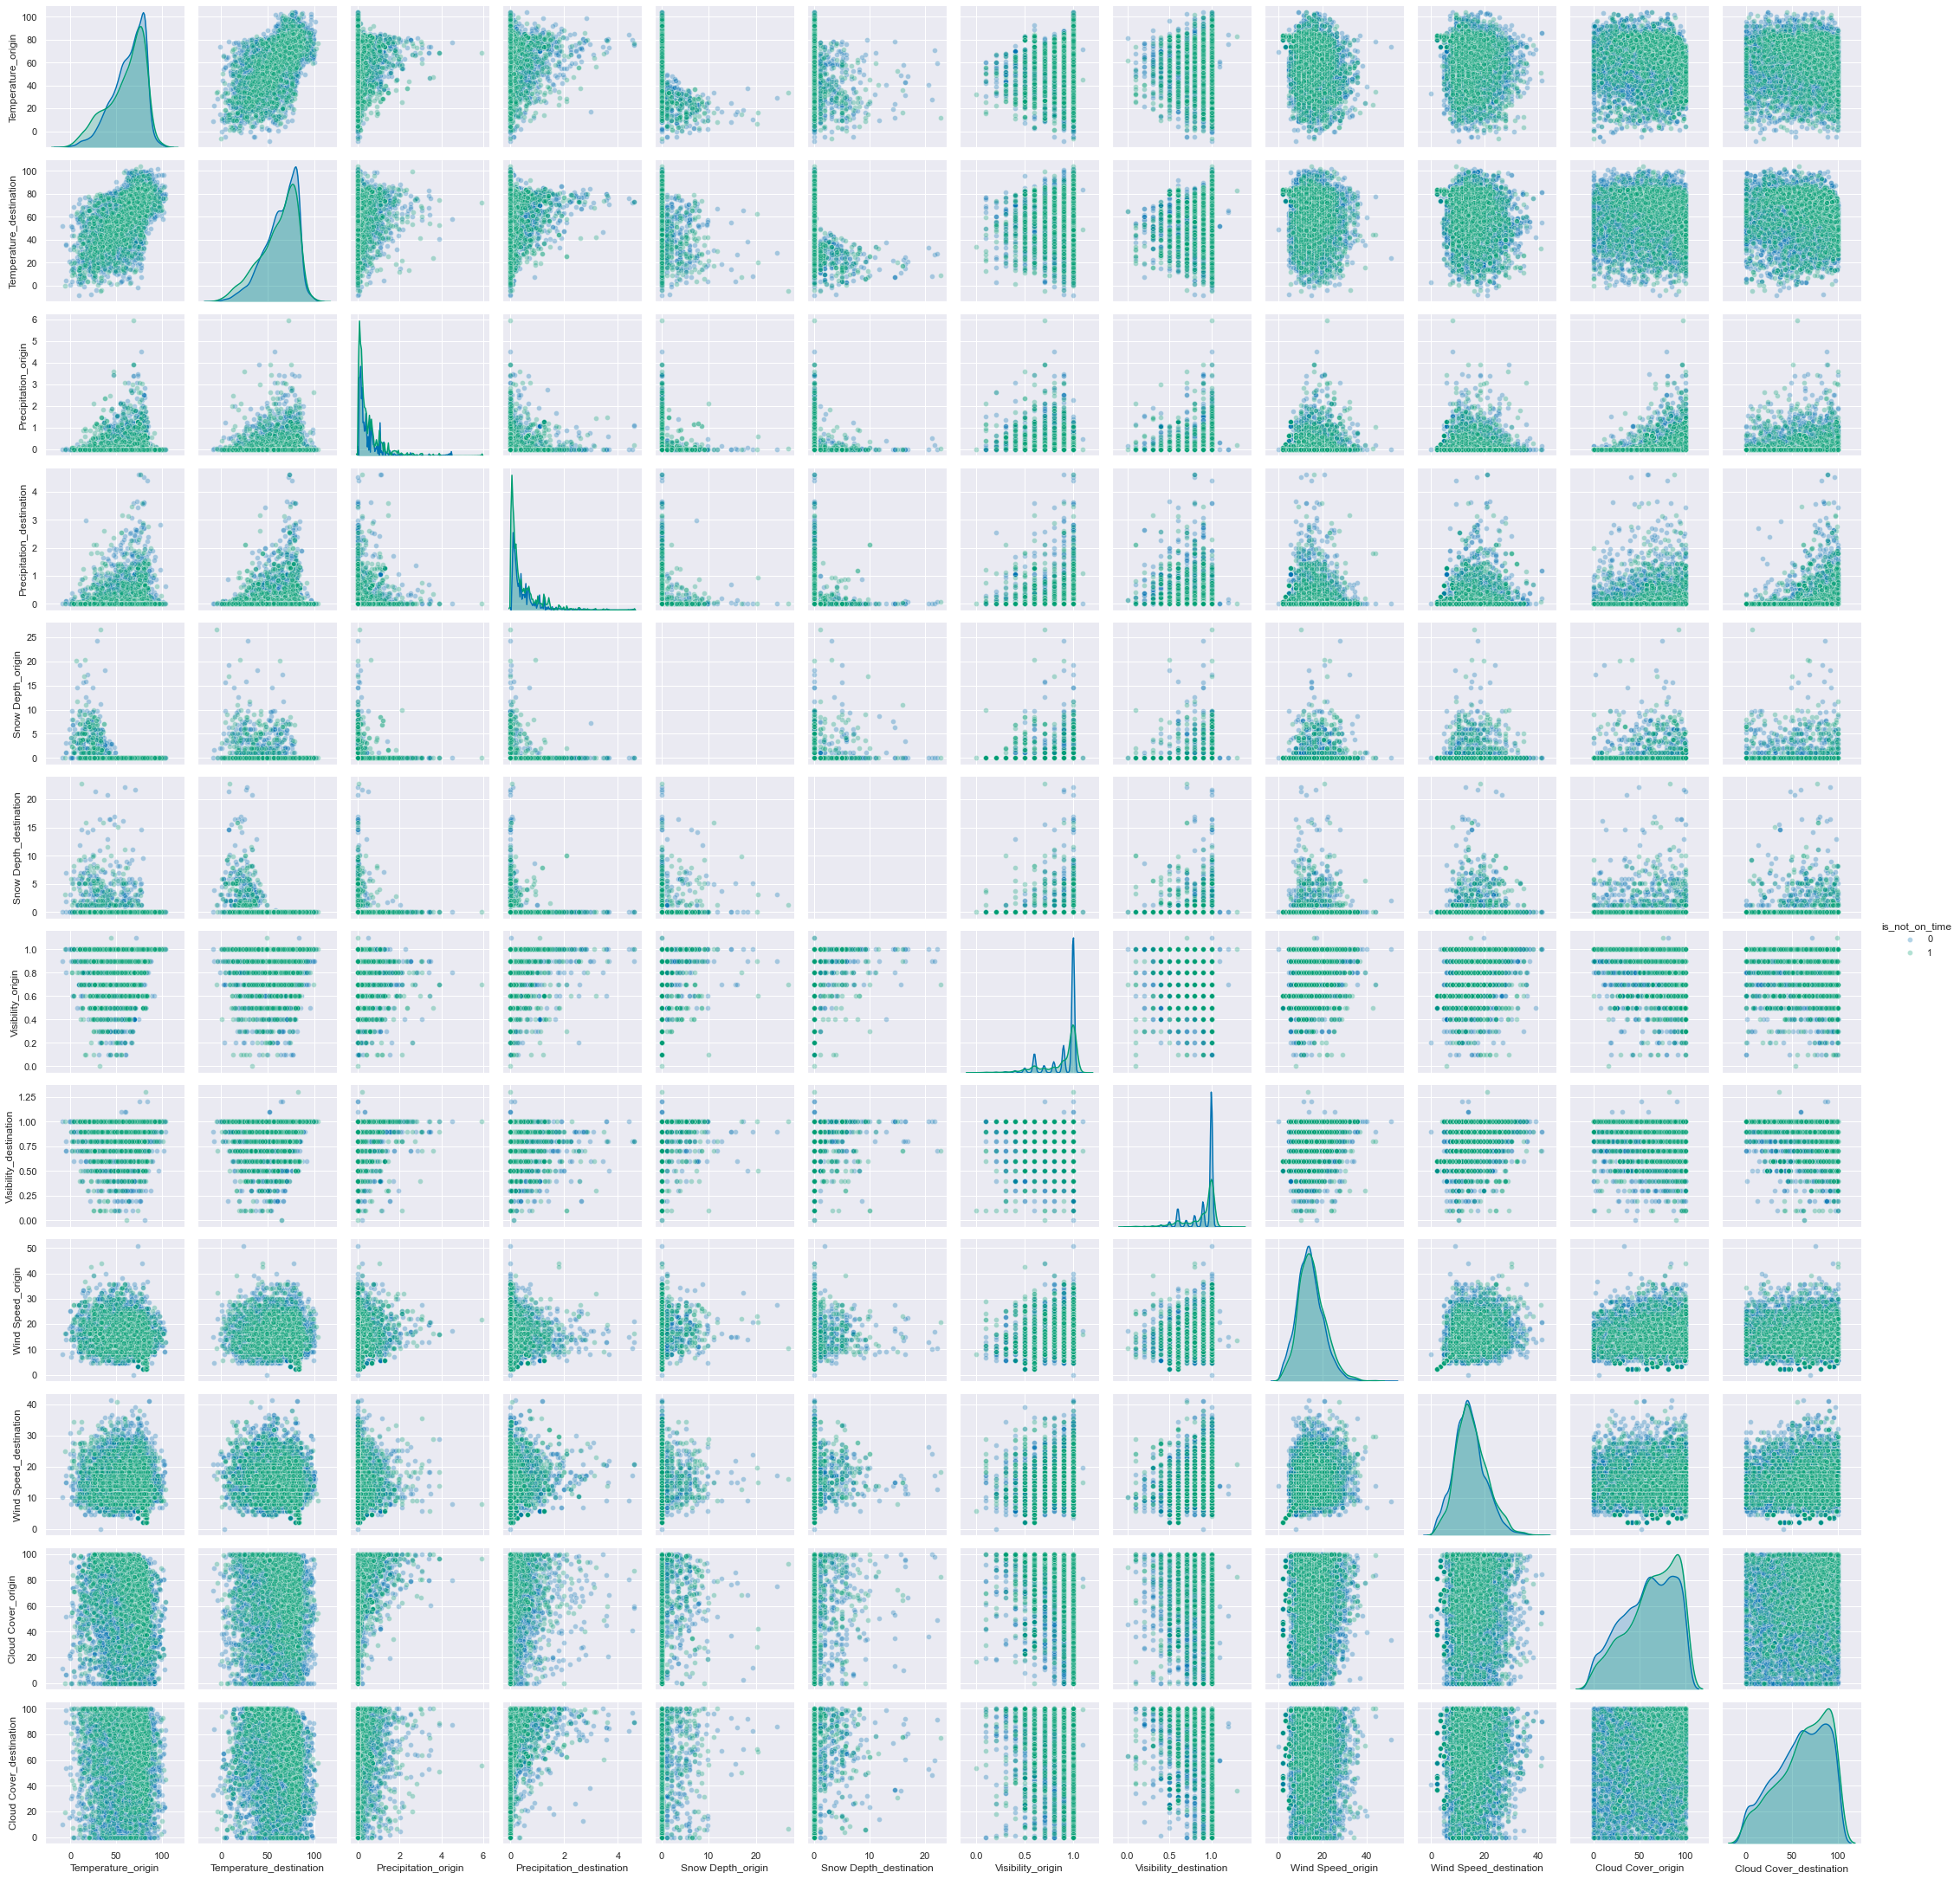

In [781]:
pairplot_features(sample_df[weather_numerical_features + target])

In [827]:
X, y = feature_target_selection(all_features, target, sample_df)

In [828]:
X_train_val, X_test, y_train_val, y_test = initial_split(X, y.values.ravel())
X_train, X_val, y_train, y_val = second_split(X_train_val, y_train_val)

In [831]:
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)

In [859]:
lm = LogisticRegression(penalty='none', max_iter=10000)
rf = RandomForestClassifier()

In [860]:
cv_records_df = cv(rf, X_train_val_scaled, y_train_val, cv_records_df)

Model name: RandomForestClassifier
Hyperparameters: 

Mean train F1:             0.969
Mean val F1:               0.199
Mean train precision:      0.994
Mean val precision:        0.571
Mean train recall:         0.944
Mean val recall:           0.120
Mean train accuracy:       0.988
Mean val accuracy:         0.805
Mean train AUC:            0.995
Mean val AUC:              0.680
iteration_desc: Used default RandomForestClassifier hyperparameters
feature_engineering: 


In [861]:
cv_records_df.tail()

,model,iteration_desc,feature_engineering,hyperparameter_tuning,mean_train_f1,mean_val_f1,mean_train_precision,mean_val_precision,mean_train_recall,mean_val_recall,mean_train_accuracy,mean_val_accuracy,mean_train_AUC,mean_val_AUC
21,LogisticRegression,,added weather_numerical_features,"max_iter=10000, penalty='none'",0.11,0.10,0.60,0.59,0.06,0.06,0.80,0.80,0.67,0.67
22,LogisticRegression,,took out temperature/cloud cover features beca...,"max_iter=10000, penalty='none'",0.11,0.11,0.60,0.60,0.06,0.06,0.80,0.80,0.67,0.67
23,LogisticRegression,,added weather_categorical_features,"max_iter=10000, penalty='none'",0.11,0.11,0.61,0.61,0.06,0.06,0.80,0.80,0.67,0.67
24,LogisticRegression,scaled features,,"max_iter=10000, penalty='none'",0.11,0.11,0.60,0.60,0.06,0.06,0.80,0.80,0.67,0.67
25,RandomForestClassifier,Used default RandomForestClassifier hyperparam...,,,0.97,0.20,0.99,0.57,0.94,0.12,0.99,0.81,0.99,0.68


In [583]:
def print_model_coef(X, model):
    for feature, coef in zip(X.columns, model.coef_[0]):
        print(f'{feature: <40} {coef:.2f}')

In [838]:
print_model_coef(X, lm)

airline_avg_arrival_delay                0.08
origin_airport_avg_flights_per_day       0.02
origin_airport_avg_departure_delay       0.12
destination_airport_avg_flights_per_day  0.05
destination_airport_avg_arrival_delay    0.12
month_avg_delay                          0.22
day_of_week_avg_delay                    0.05
American Airlines Inc.                   -0.02
American Eagle Airlines Inc.             0.00
Atlantic Southeast Airlines              -0.01
Delta Air Lines Inc.                     -0.11
Frontier Airlines Inc.                   0.03
Hawaiian Airlines Inc.                   -0.02
JetBlue Airways                          0.03
Skywest Airlines Inc.                    0.02
Southwest Airlines Co.                   0.05
Spirit Air Lines                         0.05
US Airways Inc.                          -0.01
United Air Lines Inc.                    0.00
Virgin America                           0.00
is_thanksgiving_period                   -0.04
is_xmas_period              

In [824]:
lm.predict_proba(X_train)

array([[0.89851888, 0.10148112],
       [0.72847421, 0.27152579],
       [0.64470081, 0.35529919],
       ...,
       [0.84555101, 0.15444899],
       [0.5916588 , 0.4083412 ],
       [0.50830005, 0.49169995]])

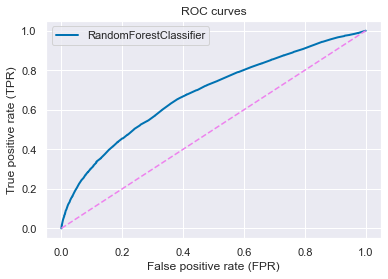

In [867]:
fpr, tpr, thresholds = plot_ROC(rf, X_train, X_val, y_train, y_val)

In [843]:
confusion_matrix(y_train_val, lm.predict(X_train_val_scaled))

array([[63280,   624],
       [15126,   942]])

In [844]:
get_best_threshold_from_roc_curve(fpr, tpr, thresholds)

(0.2422132311611555, 0.19975022345947277)

In [850]:
sv_records_df = pd.DataFrame()

In [858]:
sv_records_df.head()

,feature_engineering,hyperparameter_tuning,iteration_desc,mean_train_AUC,mean_train_accuracy,mean_train_f1,mean_train_precision,mean_train_recall,mean_val_AUC,mean_val_accuracy,mean_val_f1,mean_val_precision,mean_val_recall,model
0,,"max_iter=10000, penalty='none'",testing sv_records_df,0.62,0.64,0.4,0.3,0.59,0.62,0.63,0.39,0.29,0.59,LogisticRegression


In [857]:
_, sv_records_df = split_and_simple_validate(lm, X_train_val, y_train_val, sv_records_df, threshold=0.2, scale=True)

Train F1:                                 0.40
Val F1:                                   0.39
Train precision:                          0.30
Val precision:                            0.29
Train recall:                             0.59
Val recall:                               0.59
Train accuracy:                           0.64
Val accuracy:                             0.63
Train AUC:                                0.62
Val AUC:                                  0.62

Feature coefficients:

airline_avg_arrival_delay                 0.07
origin_airport_avg_flights_per_day        0.03
origin_airport_avg_departure_delay        0.12
destination_airport_avg_flights_per_day   0.04
destination_airport_avg_arrival_delay     0.12
month_avg_delay                           0.23
day_of_week_avg_delay                     0.04
American Airlines Inc.                   -0.03
American Eagle Airlines Inc.             -0.00
Atlantic Southeast Airlines              -0.00
Delta Air Lines Inc.                

## Error Analysis ##

In [460]:
error_analysis_df = X_train_val.copy(deep=True)

In [461]:
error_analysis_df['actual_is_not_on_time'] = y_train_val
error_analysis_df['pred_is_not_on_time'] = lm.predict(X_train_val)

In [468]:
cond_list = [((error_analysis_df['actual_is_not_on_time'] == 1) & (error_analysis_df['pred_is_not_on_time'] == 1)),
             ((error_analysis_df['actual_is_not_on_time'] == 0) & (error_analysis_df['pred_is_not_on_time'] == 0)),
             ((error_analysis_df['actual_is_not_on_time'] == 1) & (error_analysis_df['pred_is_not_on_time'] == 0)),
             ((error_analysis_df['actual_is_not_on_time'] == 0) & (error_analysis_df['pred_is_not_on_time'] == 1))] 
cond_values = ['tp', 'tn', 'fn', 'fp']

In [469]:
error_analysis_df['actual_v_pred'] = np.select(cond_list, cond_values)

In [473]:
sample_df.iloc[[46481, 24902, 60199, 18927, 6038]]

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day,destination_airport_avg_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq,month_avg_delay,day_of_week_avg_delay,is_thanksgiving_period,is_xmas_period,is_night_departure,is_night_arrival
46481,2015,5,28,4,DL,17,N126DL,ATL,LAX,1916,1928,12.0,14.0,1942,299,333.0,248.0,1947,2050,71.0,2115,2201,46.0,0,0,None,34.0,0.0,0.0,0.0,12.0,Delta Air Lines Inc.,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,33.64,-84.43,Los Angeles International Airport,Los Angeles,CA,33.94,-118.41,1,1.82,34,81,14925,0.77,0,0,0,1,0,0,0,0,0,0,0,0,0,4.91,5857.0,16.05,8.39,3377.0,9.25,1067.0,7.15,852.0,5.71,7.53,8.48,0,0,0,1
24902,2015,4,2,4,WN,1251,N8639B,BWI,JAX,0835,0830,-5.0,18.0,0848,130,119.0,95.0,663,1023,6.0,1045,1029,-16.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,Baltimore-Washington International Airport,Baltimore,MD,39.18,-76.67,Jacksonville International Airport,Jacksonville,FL,30.49,-81.69,0,6.72,62,273,21638,1.55,0,0,0,0,0,0,0,0,1,0,0,0,0,11.83,1496.0,4.10,9.18,285.0,0.78,2490.0,11.51,2737.0,12.65,5.08,8.48,0,0,0,0
60199,2015,11,21,6,UA,228,N75428,SFO,ORD,0641,0657,16.0,83.0,0820,259,339.0,240.0,1846,1420,16.0,1300,1436,96.0,0,0,None,80.0,0.0,16.0,0.0,0.0,United Air Lines Inc.,San Francisco International Airport,San Francisco,CA,37.62,-122.37,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,1,8.19,29,104,8978,1.48,0,0,0,0,0,0,0,0,0,0,0,1,0,8.89,2560.0,7.01,14.01,4910.0,13.45,1153.0,12.84,888.0,9.89,2.96,4.83,0,0,0,0
18927,2015,3,31,2,WN,857,N906WN,MCI,MDW,0950,0948,-2.0,7.0,0955,75,72.0,59.0,405,1054,6.0,1105,1100,-5.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,Kansas City International Airport,Kansas City,MO,39.30,-94.71,Chicago Midway International Airport,Chicago,IL,41.79,-87.75,0,6.72,62,273,21638,1.55,0,0,0,0,0,0,0,0,1,0,0,0,0,4.31,681.0,1.87,7.55,1421.0,3.89,2490.0,11.51,2737.0,12.65,8.49,7.64,0,0,0,0
6038,2015,12,20,7,EV,3827,N12166,IND,IAH,0746,0744,-2.0,10.0,0754,173,157.0,133.0,844,0907,14.0,0939,0921,-18.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,Indianapolis International Airport,Indianapolis,IN,39.72,-86.29,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,12.28,431.0,1.18,8.96,2596.0,7.11,902.0,9.13,964.0,9.76,9.97,7.56,0,1,0,0


In [475]:
confusion_matrix(y_train_val, lm.predict(X_train_val))

array([[63770,   132],
       [15977,   121]])

In [474]:
error_analysis_df['actual_v_pred'].value_counts()

tn    63770
fn    15977
fp      132
tp      121
Name: actual_v_pred, dtype: int64

In [479]:
cols = ['actual_is_not_on_time', 'pred_is_not_on_time', 'actual_v_pred'] 

In [485]:
combined_error_analysis_df = sample_df.join(error_analysis_df[cols])

In [483]:
error_analysis_df.sample(5)

,airline_avg_delay,origin_airport_avg_delay,origin_airport_avg_flights_per_day,destination_airport_avg_delay,destination_airport_avg_flights_per_day,month_avg_delay,day_of_week_avg_delay,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,is_thanksgiving_period,is_xmas_period,is_night_departure,is_night_arrival,actual_is_not_on_time,pred_is_not_on_time,actual_v_pred
77001,9.68,-4.51,0.13,2.91,4.55,8.78,6.63,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,tn
14395,6.72,10.39,5.19,5.07,15.99,8.78,7.64,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,fn
6187,11.72,9.18,0.73,8.96,7.11,9.97,7.56,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,tn
8050,11.72,9.92,4.70,11.93,1.60,10.45,7.56,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,fn
70926,9.68,0.62,0.11,8.84,6.94,12.37,7.56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,tn


In [477]:
error_analysis_df[error_analysis_df['actual_v_pred'] == 'fn'].sample(5)

,airline_avg_delay,origin_airport_avg_delay,origin_airport_avg_flights_per_day,destination_airport_avg_delay,destination_airport_avg_flights_per_day,month_avg_delay,day_of_week_avg_delay,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,is_thanksgiving_period,is_xmas_period,is_night_departure,is_night_arrival,actual_is_not_on_time,pred_is_not_on_time,actual_v_pred
11737,6.72,8.64,2.44,8.09,2.92,2.96,7.64,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,fn
33920,6.64,7.92,4.31,8.34,0.37,9.97,7.56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,fn
12641,6.72,6.90,1.39,6.69,1.86,7.53,7.64,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,fn
70401,9.68,16.80,0.35,8.84,6.94,10.45,6.63,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,fn
33275,6.64,8.08,4.68,8.05,4.72,0.41,4.83,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,fn


In [488]:
combined_error_analysis_df[combined_error_analysis_df['actual_v_pred'] == 'fn'].sample(5)

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day,destination_airport_avg_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq,month_avg_delay,day_of_week_avg_delay,is_thanksgiving_period,is_xmas_period,is_night_departure,is_night_arrival,actual_is_not_on_time,pred_is_not_on_time,actual_v_pred
35501,2015,12,28,1,AA,566,N556UW,PHX,MCO,1730,1811,41.0,14.0,1825,235,231.0,207.0,1849,2352,10.0,2325,0002,37.0,0,0,None,0.0,0.0,7.0,30.0,0.0,American Airlines Inc.,Phoenix Sky Harbor International Airport,Phoenix,AZ,33.43,-112.01,Orlando International Airport,Orlando,FL,28.43,-81.32,1,6.64,46,185,12662,1.82,1,0,0,0,0,0,0,0,0,0,0,0,0,6.27,2530.0,6.93,8.23,1867.0,5.12,1166.0,9.21,1006.0,7.95,9.97,11.00,0,0,0,1,1.0,0.0,fn
66111,2015,3,20,5,UA,549,N404UA,PHL,ORD,1620,1917,177.0,25.0,1942,146,140.0,103.0,678,2025,12.0,1746,2037,171.0,0,0,None,0.0,0.0,0.0,153.0,18.0,United Air Lines Inc.,Philadelphia International Airport,Philadelphia,PA,39.87,-75.24,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,1,8.19,29,104,8978,1.48,0,0,0,0,0,0,0,0,0,0,0,1,0,5.84,1162.0,3.18,14.01,4910.0,13.45,1153.0,12.84,888.0,9.89,8.49,6.63,0,0,0,0,1.0,0.0,fn
74603,2015,5,11,1,OO,2772,N906SW,PHX,FAT,1340,1400,20.0,23.0,1423,105,105.0,77.0,493,1540,5.0,1525,1545,20.0,0,0,None,0.0,0.0,0.0,20.0,0.0,Skywest Airlines Inc.,Phoenix Sky Harbor International Airport,Phoenix,AZ,33.43,-112.01,Fresno Yosemite International Airport,Fresno,CA,36.78,-119.72,1,9.68,22,181,10109,2.01,0,0,0,0,0,0,0,1,0,0,0,0,0,6.27,2530.0,6.93,8.21,115.0,0.32,682.0,6.75,1110.0,10.98,7.53,11.00,0,0,0,0,1.0,0.0,fn
7975,2015,10,13,2,EV,4323,N14542,15096,11618,1125,1113,-12.0,56.0,1209,65,107.0,43.0,195,1252,8.0,1230,1300,30.0,0,0,None,30.0,0.0,0.0,0.0,0.0,Atlantic Southeast Airlines,None,None,None,NaN,NaN,None,None,None,NaN,NaN,1,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,8.08,1710.0,4.68,8.05,1721.0,4.72,902.0,9.13,964.0,9.76,0.41,7.64,0,0,0,0,1.0,0.0,fn
73378,2015,11,28,6,OO,5338,N494CA,LAX,MRY,1838,1847,9.0,33.0,1920,72,82.0,45.0,266,2005,4.0,1950,2009,19.0,0,0,None,10.0,0.0,0.0,9.0,0.0,Skywest Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,33.94,-118.41,Monterey Regional Airport (Monterey Peninsula ...,Monterey,CA,36.59,-121.84,1,9.68,22,181,10109,2.01,0,0,0,0,0,0,0,1,0,0,0,0,0,8.61,3441.0,9.43,10.47,55.0,0.15,682.0,6.75,1110.0,10.98,2.96,4.83,1,0,0,0,1.0,0.0,fn
